In [ ]:
'''
for classes in imageFiles:
    for image in classes:
        img = cv2.imread(image)
        name = image[5:]
        resized_image=cv2.resize(img,(224,224)) 

        cv2.imwrite('new_data/' + name,resized_image)
'''

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torchvision as T
import torch.utils.data as dat
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
# check GPU availability
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

In [3]:
print(dev)

cuda:0


In [4]:
np.random.seed(7)

In [5]:
dataDir = 'new_data/train/'
classNames = os.listdir(dataDir)  # Creates list of class names
numClass = len(classNames)        # Counts number of classses
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEach = [len(imageFiles[i]) for i in range(numClass)]       # Count of each image class
for i in range(numClass):
    print("Category",classNames[i],"has",numEach[i],"images")

Category seborrheic_keratosis has 254 images
Category melanoma has 374 images
Category nevus has 1372 images


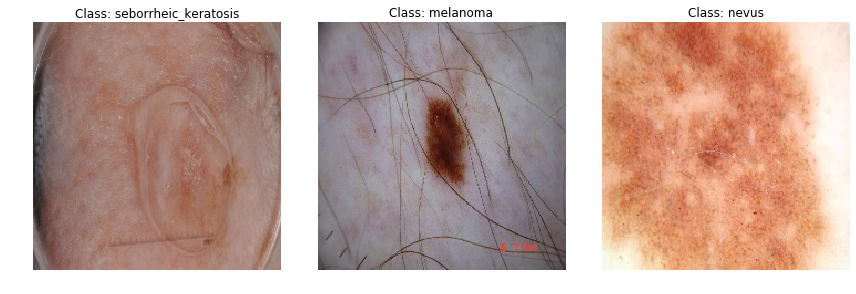

In [6]:
plt.subplots(3,1,figsize=(12,12))
for i in range(numClass): 
    im = Image.open(imageFiles[i][np.random.randint(numEach[i])])   # Randomly sample one image per class
    arr = np.array(im)
    plt.subplot(1,3,i+1)
    plt.title('Class: '+classNames[i])
    plt.axis('off')
    plt.imshow(arr,vmin=0,vmax=255)
plt.tight_layout()

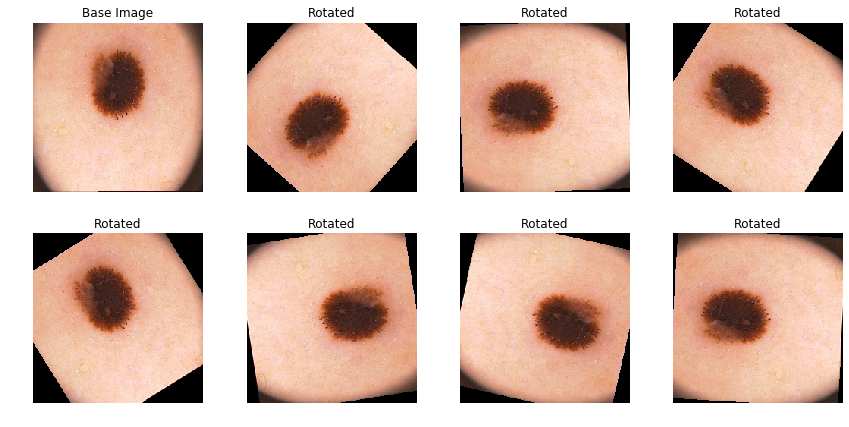

In [7]:
melanomaClass = classNames.index('melanoma')
maxRot = 180
randRot = T.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[melanomaClass][1])
plt.subplots(2,4,figsize=(12, 6))
plt.subplot(2,4,1)
plt.axis('off')
plt.title('Base Image')
plt.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(7):
    randImage = randRot(baseImage)
    plt.subplot(2,4,i+2)
    plt.title('Rotated')
    plt.axis('off')
    plt.imshow(np.array(randImage),vmin=0,vmax=255)
plt.tight_layout()
plt.show()

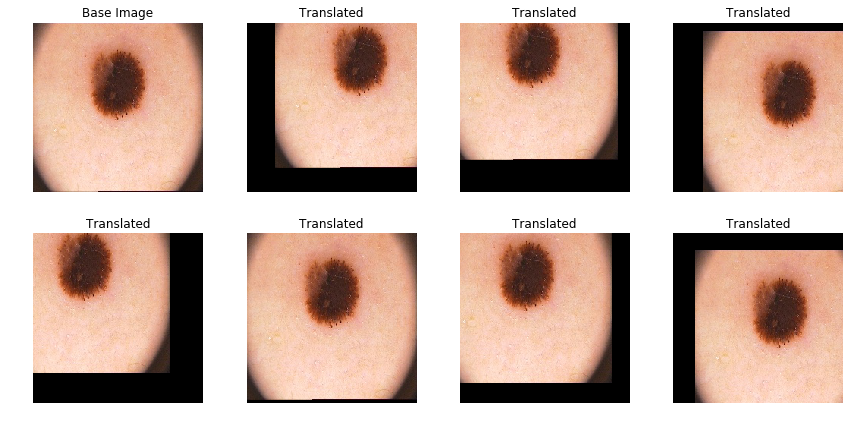

In [8]:
maxTrX = 0.2
maxTrY = 0.2
randTr = T.transforms.RandomAffine(0,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[melanomaClass][1])
plt.subplots(2,4,figsize=(12,6))
plt.subplot(2, 4,1)
plt.title('Base Image')
plt.axis('off')
plt.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(7):
    randImage = randTr(baseImage)
    arr = np.array(im)
    plt.subplot(2, 4,i+2)
    plt.title('Translated')
    plt.axis('off')
    plt.imshow(np.array(randImage),vmin=0,vmax=255)
plt.tight_layout()


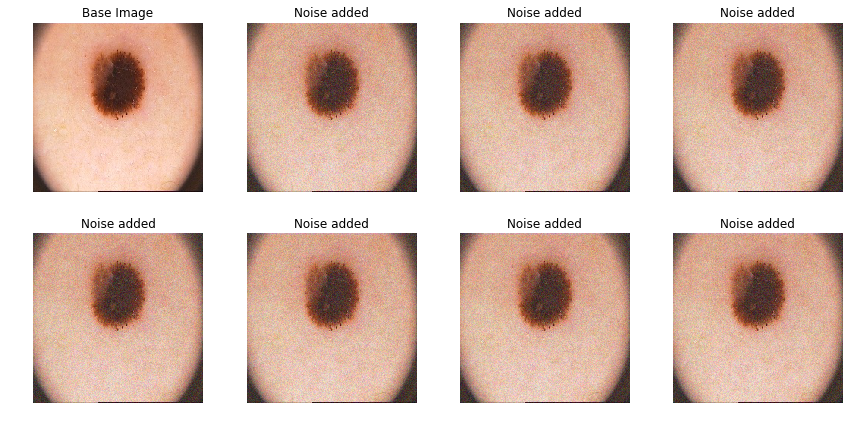

In [9]:
noiseStrength = 0.15
baseImage = Image.open(imageFiles[melanomaClass][1])
imageWidth, imageHeight, imDim = np.array(baseImage).shape[0], np.array(baseImage).shape[1], np.array(baseImage).shape[2]  # Image dimensions
plt.subplots(2,4,figsize=(12, 6))
plt.subplot(2, 4,1)
plt.title('Base Image')
plt.axis('off')
plt.imshow(np.array(baseImage),vmin=0,vmax=255)
for i in range(7):
    noise = np.random.random((imageWidth,imageHeight, imDim))
    arr = np.array(baseImage) *(1-noiseStrength)+255*noiseStrength*noise
    plt.subplot(2, 4,i+2)
    plt.title('Noise added')
    plt.axis('off')
    plt.imshow((arr).astype(np.uint8))

plt.tight_layout()

In [10]:
def scaleImage(x):
    y = np.array(x)
    if(np.min(y) < np.max(y)):  # Assuming the image isn't empty, rescale so its values run from 0 to 255
        y = 255.0*(y - 1.0*np.min(y))/(1.0*np.max(y) - np.min(y))
    z = Image.fromarray(np.uint8(y))
    return z


In [11]:
numPerClass = 1500
maxRot = 180
maxTrX = 0.2
maxTrY = 0.2
noiseStrength = 0.15
imageWidth,imageHeight, imDim = 224, 224, 3
randAff = T.transforms.RandomAffine(maxRot,translate=(maxTrX,maxTrY), resample=Image.BICUBIC)
for i in range(numClass):
    print('Augmenting class',classNames[i])
    for j in range(numPerClass - numEach[i]):
        if j % 200 == 0:
            print('Adding image number',j)
        imageID = np.random.randint(numEach[i])
        baseImage = Image.open(imageFiles[i][imageID])
        baseImage = np.array(baseImage)
        baseImage = cv2.resize(baseImage, (224, 224))
        randImage = randAff(scaleImage(baseImage))
        noise = np.random.random((imageWidth,imageHeight, imDim))
        arr = np.array(randImage)*(1-noiseStrength)+255*noiseStrength*noise
        finalImage = Image.fromarray(np.uint8(arr))
        fname = imageFiles[i][imageID][:-5]+str(j)+'a.jpeg'
        finalImage.save(fname)

        

Augmenting class seborrheic_keratosis
Adding image number 0
Adding image number 200
Adding image number 400
Adding image number 600
Adding image number 800
Adding image number 1000
Adding image number 1200
Augmenting class melanoma
Adding image number 0
Adding image number 200
Adding image number 400
Adding image number 600
Adding image number 800
Adding image number 1000
Augmenting class nevus
Adding image number 0


In [12]:
imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEachAug = [len(imageFilesAug[i]) for i in range(numClass)]       # Count of each image class

for i in range(numClass):
    print("Category",classNames[i],"has",numEachAug[i],"images")


Category seborrheic_keratosis has 1500 images
Category melanoma has 1500 images
Category nevus has 1500 images
